# Данные 
В некотором *городе N* на каждом автобусе/троллейбусе/трамвае установлены GPS трекеры, которые с некоторым промежутком времени передают информацию о своем местоположении на специальный сервер. 

Данные для всех транспортных средства одного маршрута непрерывно записывались на протяжении недели, потом GPS координаты (широта и долгота) были спроецированы на плоскость с использованием [проекции Меркатора](https://ru.wikipedia.org/wiki/%D0%9F%D1%80%D0%BE%D0%B5%D0%BA%D1%86%D0%B8%D1%8F_%D0%9C%D0%B5%D1%80%D0%BA%D0%B0%D1%82%D0%BE%D1%80%D0%B0) и некоторого линейного преобразования. Эти данные записаны в файле **../data/transport_log.zip** в виде:

>    **1447037729**&nbsp;&nbsp;&lt;tab&gt;&nbsp;&nbsp;**3054.619968**&nbsp;&nbsp;&lt;tab&gt;&nbsp;&nbsp;**2409.828279**&nbsp;&nbsp;&lt;tab&gt;&nbsp;&nbsp;**570d8**

поля разделены табуляцией. Здесь:
- **1447037729** - [UNIX-время](https://ru.wikipedia.org/wiki/UNIX-%D0%B2%D1%80%D0%B5%D0%BC%D1%8F), которое без труда можно преобразовать во что-то разумное с помощью стандартной библиотеки [Python](https://docs.python.org/2/library/datetime.html#datetime.date.fromtimestamp).
- **3054.619968** - координата "x"
- **2409.828279** - координата "y"
- **570d8** - уникальный идентификатор транспортного средства, от которого получен сигнал. 

Маршрут автобосов "туда" не совпадает с маршрутом "обратно". Известно, что в направлении, которое мы назовем "туда"  первая остановка имеет координаты:

>   **(11038.08464497, 8253.17542416)**

последняя:

>   **(283.08479678,  163.45489494)**


# Задачи

- Отобразить все точки на плоскости

         time             x            y number
0  1447037752  10790.502576  7289.575506  80c48
1  1447037729   3054.619968  2409.828279  570d8
2  1447037635   1220.080874   575.826726  279c4
3  1447037741   6918.183471  4969.208485  f9cf0
4  1447037373  11409.219599  8320.040473  fd845


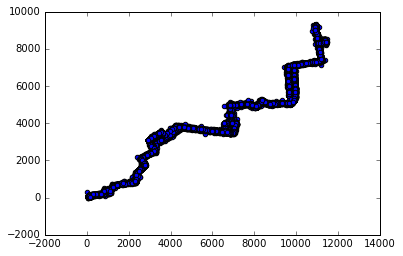

In [1]:
import zipfile 
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

u_cols = ['time', 'x', 'y', 'number']

with zipfile.ZipFile('../data/transport_log.zip', 'r') as zf:
    with zf.open('transport_log.txt', 'r') as f:
        df = pd.read_csv(f, sep = '\t', names = u_cols)

print(df.head())
plt.scatter(df[[1]], df[[2]])
plt.show()

- Отобразить в bar plot зависимость числа точек от часа (0-23). По оси "X" столбцы с метками 0-23, по оси "Y" - число соответствующих точек в логе.

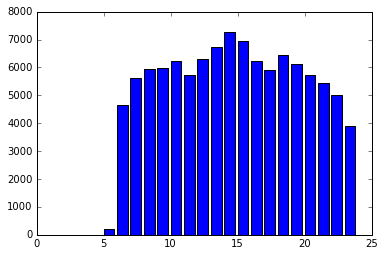

In [2]:
import numpy as np
import time

x = np.arange(0, 24)
y = np.zeros(24)

for i in range(len(df[[0]].values)):
    y[time.localtime(df[[0]].values[i])[3]] = y[time.localtime(df[[0]].values[i])[3]] + 1
    
plt.bar(x,y)
plt.show()

- Выделить из лога подпоследовательности, соответствующие гарантировано полным маршрутам в направлении "туда". То есть автобус должен пройти первую остановку с обозначенными выше координатами, затем последнюю.

In [3]:
import datetime

In [4]:
df = df.sort_values(by=['number', 'time'])
start = [11038.08464497, 8253.17542416]
finish = [283.08479678, 163.45489494]

data = df.as_matrix()

eps = 50
dist = lambda c, d: np.sqrt((c[0] - d[0]) ** 2 + (c[1] - d[1]) ** 2)
first_like = lambda x: dist(x, start) < eps
last_like = lambda x: dist(x, finish) < eps

sequences = []
temp = []
view = [('time', 'object'), ('x', float), ('y', float), ('id', 'S5')]
for i in range(len(data)):
    temp.append((datetime.datetime.fromtimestamp(int(data[i][0])), float(data[i][1]), float(data[i][2]), data[i][3]))

data2 = np.array(temp, dtype=view)
numbers = list(set(data2['id']))
sequence = []
full = False
add = False
view = [('time', 'object'), ('x', float), ('y', float), ('id', 'S5'), ('speed', float)]
for number in numbers:
    number_data = data2[data2['id'] == number]
    number_count = number_data.shape[0]
    np.sort(number_data, order='time')
    for i in range(number_count):
        current = number_data[i]
        previous = number_data[i-1]
        if first_like([previous[1], previous[2]]):
            full = True
        if full:
            time = (number_data[i]['time']-number_data[i-1]['time']).total_seconds()
            if (0 < time < 300):
                speed = dist([number_data[i]['x'], number_data[i]['y']],\
                             [number_data[i-1]['x'], number_data[i-1]['y']]) / time
            else:
                full = False
                sequence = []
                continue
            if last_like([current[1], current[2]]):
                add = True

            current = list(current)
            current.append(speed)
            sequence.append(tuple(current))
            if add:
                add = False
                full = False
                sequence = np.array(sequence, dtype=view)
                if sequences == []:
                    sequences = sequence
                    sequence = []
                else:
                    sequences = np.concatenate((sequences, sequence))
                    sequence = []


#print(sequences)
seq_elements_number=sequences.shape[0]
print(seq_elements_number)



14566


C:\Users\Anastasia\Anaconda3\lib\site-packages\ipykernel\__main__.py:51: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.


- По данным из предыдущего пункта построить приближенный маршрут в виде кусочно-линейно функции, причем линейные компоненты должны иметь одинаковую длину. Отобразить таким образом, чтобы каждый участок имел цвет в зависимости от средней скорости прохождения участка. 

In [5]:
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans

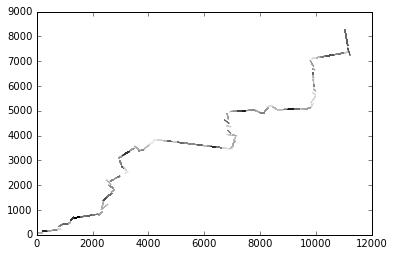

In [6]:
linear_components = []

average_speed_min = 50
average_speed_max = -50
coordinates = np.zeros((seq_elements_number, 2))
coordinates[:, 0] = sequences['x']
coordinates[:, 1] = sequences['y']

number_of_clusters = 100
K_Means = KMeans(n_clusters=number_of_clusters)

clusters = K_Means.fit_predict(coordinates)

for cluster in range(0, number_of_clusters-1):
    cluster_data = sequences[clusters == cluster]
    x = cluster_data['x'].reshape(-1, 1)
    y = cluster_data['y']

    average_speed = np.mean(cluster_data['speed'])
    if average_speed > average_speed_max:
        average_speed_max = average_speed
    if average_speed < average_speed_min:
        average_speed_min = average_speed

    Linear_Regression = LinearRegression()
    Linear_Regression.fit(x, y)
    y = Linear_Regression.predict(x)
    linear_components.append((x, y, average_speed))

for x, y, speed in linear_components:
    speed = 1-((speed - average_speed_min) / (average_speed_max - average_speed_min))
    plt.plot(x, y, color=str(speed), linewidth=1)
plt.show()